Загружаем библиотеки:

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

Изображение для проверки:

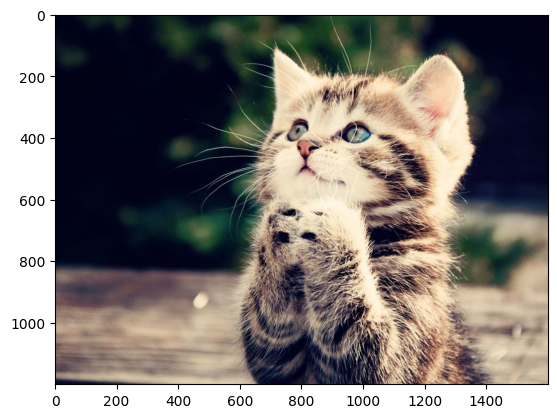

In [ ]:
img = Image.open('Cat.jpg')
fig = plt.figure()
plt.imshow(img)
plt.show()

Препроцессинг:

In [ ]:
transform = Compose([
 Resize((224, 224)),
 ToTensor(),
])
x = transform(img)
x = x.unsqueeze(0)
print(x.shape)
torch.Size([1,3,224,224])

torch.Size([1, 3, 224, 224])


torch.Size([1, 3, 224, 224])

Разбить изображение на несколько фрагментов и сгладить их:

In [ ]:
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',
s1=patch_size, s2=patch_size)

Проецирование фрагментов:

In [ ]:
class PatchEmbedding(nn.Module):
 def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
  self.patch_size = patch_size
  super().__init__()
  self.projection = nn.Sequential(nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size), Rearrange('b e (h) (w) -> b (h w) e')) # это разбивает изображение на патчи s1xs2, а затем сглаживает их

 def forward(self, x: Tensor) -> Tensor:
   x = self.projection(x)
   return x

Тестирование:

In [ ]:
PatchEmbedding()(x).shape : torch.Size([1, 196, 768])

In [ ]:
img_size = 224
class PatchEmbedding(nn.Module):
 def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
  self.patch_size = patch_size
  super().__init__()
  self.projection = nn.Sequential(
  nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
  Rearrange('b e (h) (w) -> b (h w) e'),) # this breaks down the image in s1xs2 patches, and then flat them
  self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
  self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size))

 def forward(self, x: Tensor) -> Tensor:
  b, _, _, _ = x.shape
  x = self.projection(x)
  cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
  x = torch.cat([cls_tokens, x], dim=1) #prepending the cls token
  x += self.positions
  return x